In [ ]:
# Interpret and visualize variability types / labelling accuracy

In [85]:
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import sys
import sklearn
import scipy
import math
import ast
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)

In [87]:
flux = pd.read_csv("../output/flux1.csv")
err = pd.read_csv("../output/errors1.csv")
params = pd.read_csv("../output/params1.csv")

varis = [flux, err, params]
names = ['flux', 'errors', 'params']

for i in range(3):
    r2 = pd.read_csv("../output/" + names[i] + "2.csv")
    r3 = pd.read_csv("../output/" + names[i] + "3.csv")
    varis[i] = pd.concat([varis[i], r2], ignore_index=True)
    varis[i] = pd.concat([varis[i], r3], ignore_index=True)
    
flux = varis[0]
err = varis[1]
params = varis[2]
  

flux = flux.drop(flux[flux['KIC'] == 0].index)

In [88]:
rem = flux.index.tolist()

for col in tqdm(flux.columns[109:165]):
    dele = flux[flux[col] == 0].index.tolist()
    rem = list(set(rem) & set(dele))

  0%|          | 0/56 [00:00<?, ?it/s]

In [89]:
flux = flux[~flux.index.isin(rem)]
flux = flux.drop_duplicates(subset='KIC', keep="first")

err = err[err['KIC'].isin(flux['KIC'])]
err = err.drop_duplicates(subset='KIC', keep="first")

params = params[params['KIC'].isin(flux['KIC'])]
params = params.drop_duplicates(subset='KIC', keep="first")

In [143]:
df = pd.merge(flux, err, how='inner', on='KIC')

In [157]:
for i in tqdm(params.index):
    for col in params.columns[1:]:
        lst = params[col][i].strip('[] ,').replace(',', '').split()
        lst = [float(j) for j in lst]
        params.at[i, col] = lst

df['KIC'] = df['KIC'].astype(int) 
params['KIC'] = params['KIC'].astype(int) 

In [96]:
# a model for a sine curve
def func(x, a, b, c, d):
    return a*np.sin(b * x + c) + d 

# a model for a straight line
def straightLine(x, m, b):
    return m*x + b

# a model for a sinecurve that is tiled on an axis
def func_tilt(x, a, b, c, d, e):
    return a*np.sin(b * x + c) + d + e*x

# a model for a straight line
def flatLine(x, b):
    return 0*x + b

In [112]:
# Visualize recorded light curves from FFI data and various fits

# the time points of all the data points in order
abs = [54945.74206,54945.8670833,54946.0182163,54946.2335259,54946.3377372,54946.5495655,54946.7334679,
         54947.1662509,55062.8253608,55091.0055606,55123.0864583,55153.9797114,55182.0366329,55215.9548927,
         55216.0352649,55245.7660019,55274.7398619,55307.5350333,55336.4281441,55370.695297,55399.0571196,
         55430.8109392,55461.8291274,55492.8064711,55522.7621353,55552.0843583,55585.5760016,55614.7389024,
         55677.4444762,55706.6440223,55738.4591443,55769.477399,55801.7624176,55832.8010616,55864.8001316,
         55895.757043,55930.8619526,55958.4268791,55986.5230115,56014.5579184,56047.5173675,56077.4525238,
         56105.5895974,56137.5273556,56168.8315615,56203.8547584,56236.834641,56267.9141396,56303.6729488,
         56330.563549,56357.495041,56390.4952381]
times = np.asarray(abs) - 54833

time = Time(abs, format='mjd')
normalized = time.decimalyear

cols = [str(i) for i in abs]

def visualize(kid, y_min = None, y_max = None):
    if kid not in df['KIC'].values:
        print("KIC does not have valid FFI data.")
    else:
        df_row = df[df['KIC'] == kid].iloc[0]
        params_row = params[params['KIC']== kid].iloc[0]
        
        x_plot = normalized
        y_plot = df_row[cols]
        
        plt.figure(figsize=(10, 10)) 
        ax = plt.axes()
        ax.errorbar(x_plot, y_plot, yerr=df_row[57:109], lw = 2, capsize = 4, capthick = 1, linestyle = '')
        scatter = ax.scatter(x_plot, y_plot, c=np.where(np.abs(df_row[110:162].to_numpy()) < 3, True, False), cmap='PiYG')
        
        line_inp = np.linspace(times[0], times[-1], 500)
        line_plot = np.linspace(normalized[0], normalized[-1], 500)
        
        flat, = ax.plot(line_plot, flatLine(line_inp, params_row['flatLineParam']))
        straight, = ax.plot(line_plot, straightLine(line_inp, params_row['straightLineParam'][0], params_row['straightLineParam'][1]))
        curve, = ax.plot(line_plot, func(line_inp, params_row['curveParamL2'][0], params_row['curveParamL2'][1], params_row['curveParamL2'][2], params_row['curveParamL2'][3]))
        curtil, = ax.plot(line_plot, func_tilt(line_inp, params_row['curtilParamL2'][0], params_row['curtilParamL2'][1], params_row['curtilParamL2'][2], params_row['curtilParamL2'][3], params_row['curtilParamL2'][4]))
        
        # plt.axis('square')
        ax.set_xlabel('Year')
        ax.set_ylabel('Relative Flux')
        if (type(y_min) == int or type(y_min) == float) and (type(y_max) == int or type(y_max) == float):
            plt.ylim(y_min, y_max)
        ax.legend([flat, straight, curve, curtil], ['Flat Line', 'Straight Line', 'Curve', 'Tilted Curve'], loc='best')
        
        print("-- KIC: " + str(kid) + " --")
        plt.show()
        print("CP/CB: " + str(df_row['cpcb']))
        print("EB: " + str(df_row['eb']))
        print("Flat line L2 error: " + str(df_row['flatLineErrorL2']))
        print("Straight line L2 error: " + str(df_row['straightLineErrorL2']))
        print("Curve L2 error: " + str(df_row['curveErrorL2']))
        print("Tilted curve L2 error: " + str(df_row['curtilErrorL2']))
        print("Standard deviation: " + str(df_row['stdev']))
        print("Number of outliers: " + str(df_row['n_outliers']) + "\n")

In [ ]:
imp = improvement(df, 'straightLineErrorL2', 'straightLineParam', 'curtilErrorL2', 'curtilParamL2')

# Plot straight vs curved fit error

data = imp

x_plot = data['straightLineErrorL2']
y_plot = data['curtilErrorL2']

plt.figure(figsize=(8, 8)) 

scatter = plt.scatter(x_plot, y_plot, c=data['eb'], cmap='viridis', s=2)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=[0.0, 1.0],
           title="CP/CB Flag")
plt.xlabel('Flat Line Error L1')
plt.ylabel('Straight Line Error L1')

plt.xlim(0, 5000)
plt.ylim(0, 5000)

plt.show()

In [ ]:
# Print proportions of data that fit one curve better than another

err_labels = ['curveErrorL2',
        'straightLineErrorL2',
        'curtilErrorL2',
       'flatLineErrorL2']

par_labels = ['curveParamL2',
        'straightLineParam',
        'curtilParamL2',
        'flatLineParam']

for i in range(len(err_labels)):
    for j in range(len(err_labels)):
        if i != j:
            combo = improvement(df, err_labels[i], par_labels[i], err_labels[j], par_labels[j])
            print(err_labels[i])
            print(err_labels[j])
            print("df length: " + str(len(combo)))
            print("percentage eb: " + str(len(combo[combo['eb'] == 1]) / len(df[df['eb'] == 1])))
            print("percentage eb of data: " + str(len(combo[combo['eb'] == 1]) / len(combo)))
            print("percentage cpcb: " + str(len(combo[combo['cpcb'] == 1]) / len(df[df['cpcb'] == 1])))
            print("percentage cpcb of data: " + str(len(combo[combo['cpcb'] == 1]) / len(combo)) + "\n")

In [ ]:
# Find percentage of EBs for some # stdevs away (3+)

for i in range(-3, -8, -1):
    s = df
    repl = pd.DataFrame()
    for j in range(123, len(s.columns)):
        add = s[s.iloc[:, j] < i]
        repl = repl.append(add, ignore_index=True)
    print('percent eb: ' + str(len(repl[repl['eb'] == 1]) / len(df[df['eb'] == 1]) * 100))
    print('percent correct: ' + str(len(repl[repl['eb'] == 1]) / len(repl) * 100))
    print(len(repl))
    print()

In [ ]:
# Find outlying errors > 20000

l2 = ['flatLineErrorL2', 'straightLineErrorL2', 'curveErrorL2', 'curtilErrorL2']

rem = df.copy(deep=True)
for l in l2:
    rem = rem.drop(rem[rem[l] > 20000].index)
rem

In [ ]:
# Find percentage of data set that have large uncertainty measurements

vals = [0.1, 0.5, 1]
    
for val in vals:
    weird = pd.DataFrame()    

# big uncertainties
    for i in range(67, 119):
        add = df[df.iloc[:, i] > val]
        weird = weird.append(add, ignore_index=True)
        
    print(val)
    print(len(weird))
    print()

In [188]:
%run classify_types.ipynb

df = good()

print(len(long_term()))
print(len(mid_term()))
print(len(short_term()))
print(len(non_var()))
print(len(df[df['eb'] == 1]))
print(len(eb()))
print(len(df))
# nonvar 60-80%
print(len(non_var()) / len(df))

19301
4783
4108
95516
1313
1313
123851
0.7712170269113693


In [196]:
df['curtilErrorL2'].mean()

438.8858174782315

In [192]:
st = short_term()

In [193]:
st[st['KIC'] == 757099]

,KIC,54945.74206,54945.8670833,54946.0182163,54946.2335259,54946.3377372,54946.5495655,54946.7334679,54947.1662509,55062.8253608,55091.0055606,55123.0864583,55153.9797114,55182.0366329,55215.9548927,55216.0352649,55245.7660019,55274.7398619,55307.5350333,55336.4281441,55370.695297,55399.0571196,55430.8109392,55461.8291274,55492.8064711,55522.7621353,55552.0843583,55585.5760016,55614.7389024,55677.4444762,55706.6440223,55738.4591443,55769.477399,55801.7624176,55832.8010616,55864.8001316,55895.757043,55930.8619526,55958.4268791,55986.5230115,56014.5579184,56047.5173675,56077.4525238,56105.5895974,56137.5273556,56168.8315615,56203.8547584,56236.834641,56267.9141396,56303.6729488,56330.563549,56357.495041,56390.4952381,uncert_new_0,uncert_new_1,uncert_new_2,uncert_new_3,mod_unc_new_00,mod_unc_new_01,mod_unc_new_02,mod_unc_new_03,mod_unc_new_04,mod_unc_new_05,mod_unc_new_06,mod_unc_new_07,mod_unc_new_08,mod_unc_new_09,mod_unc_new_10,mod_unc_new_11,mod_unc_new_12,mod_unc_new_13,mod_unc_new_14,mod_unc_new_15,mod_unc_new_16,mod_unc_new_17,mod_unc_new_18,mod_unc_new_19,mod_unc_new_20,mod_unc_new_21,mod_unc_new_22,mod_unc_new_23,mod_unc_new_24,mod_unc_new_25,mod_unc_new_26,mod_unc_new_27,mod_unc_new_28,mod_unc_new_29,mod_unc_new_30,mod_unc_new_31,mod_unc_new_32,mod_unc_new_33,mod_unc_new_34,mod_unc_new_35,mod_unc_new_36,mod_unc_new_37,mod_unc_new_38,mod_unc_new_39,mod_unc_new_40,mod_unc_new_41,mod_unc_new_42,mod_unc_new_43,mod_unc_new_44,mod_unc_new_45,mod_unc_new_46,mod_unc_new_47,mod_unc_new_48,mod_unc_new_49,mod_unc_new_50,mod_unc_new_51,stdev,sigma_0,sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,sigma_6,sigma_7,sigma_8,sigma_9,sigma_10,sigma_11,sigma_12,sigma_13,sigma_14,sigma_15,sigma_16,sigma_17,sigma_18,sigma_19,sigma_20,sigma_21,sigma_22,sigma_23,sigma_24,sigma_25,sigma_26,sigma_27,sigma_28,sigma_29,sigma_30,sigma_31,sigma_32,sigma_33,sigma_34,sigma_35,sigma_36,sigma_37,sigma_38,sigma_39,sigma_40,sigma_41,sigma_42,sigma_43,sigma_44,sigma_45,sigma_46,sigma_47,sigma_48,sigma_49,sigma_50,sigma_51,Mean_Flux,Average_Error,Jitter,n_outliers,cpcb,eb,curveErrorL1,curveErrorL2,straightLineErrorL1,straightLineErrorL2,curtilErrorL1,curtilErrorL2,flatLineErrorL1,flatLineErrorL2
1,757099,1.013488,1.010054,0.997953,1.009844,0.998879,0.995125,0.995859,1.013546,0.994246,1.00519,1.010356,0.991016,0.981155,1.019919,0.985755,0.990782,0.984506,0.989966,0.978437,1.020685,0.998982,0.979769,1.023834,1.01521,0.981394,1.004319,1.002591,0.998362,0.994717,1.001557,0.998443,1.004295,1.008772,1.014491,1.052515,1.053241,1.001782,0.982918,1.03927,1.018924,1.016688,1.037179,0.971693,0.950573,0.984871,1.0,0.989164,0.993826,0.998218,1.002691,1.001638,0.977546,0.017941,0.022807,0.017341,0.018925,0.000723,0.000715,0.000919,0.000625,0.000884,0.000879,0.000911,0.001159,0.002098,0.002131,0.001822,0.001758,0.00171,0.002068,0.001924,0.00136,0.002272,0.001424,0.00132,0.002431,0.001815,0.000849,0.001832,0.001526,0.000781,0.00093,0.001623,0.000787,0.001371,0.001691,0.002505,0.002209,0.000748,0.00141,0.001806,0.000831,0.001305,0.001678,0.001154,0.002226,0.002639,0.002979,0.003015,0.002902,0.001108,0.001535,0.002761,0.001472,0.002145,0.002168,0.001631,0.002797,0.018864,0.627111,0.445046,-0.196412,0.433934,-0.147315,-0.346349,-0.307448,0.63016,-0.392904,0.187204,0.461083,-0.564152,-1.086876,0.968014,-0.843042,-0.576544,-0.909273,-0.619804,-1.230959,1.008592,-0.141863,-1.160364,1.175521,0.718365,-1.074221,0.141056,0.049461,-0.174749,-0.367959,-0.005381,-0.170437,0.139745,0.377087,0.680239,2.695948,2.734399,0.006545,-0.993421,1.993816,0.915283,0.796704,1.882971,-1.58849,-2.708058,-0.889928,-0.087909,-0.662337,-0.415198,-0.182362,0.054742,-0.001069,-1.2782,1.001658,0.001627,0.018794,0.0,0.0,0.0,450.735444,7485.143984,498.7489,10366.045629,449.165266,7540.829843,498.566784,10357.555072


In [ ]:
len(st[st['eb'] == 1]) / len(st)

In [ ]:
# white dwarf w accretion disk and a more massive star, cataclysmic binary star
st[st['KIC'] == 1026475.0]

In [47]:
# jitter < 0.001 = non var?
len(st[st['Jitter'] < 0.001]) / len(st)

0.2429271563667919

4108
-- KIC: 1573478 --


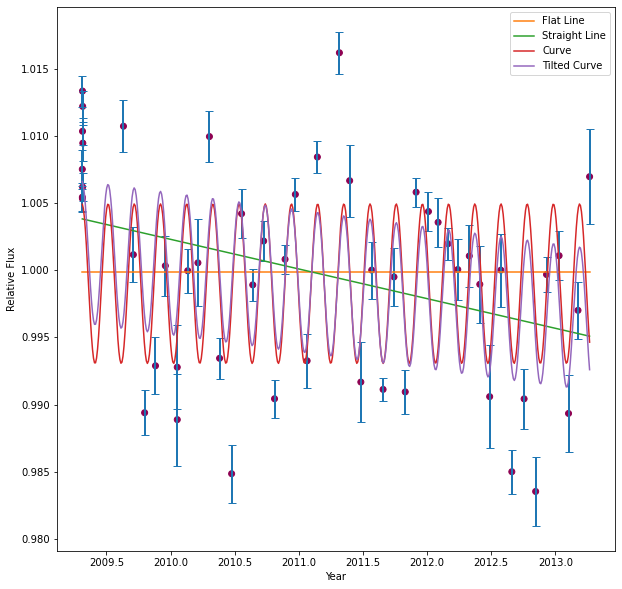

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 1338.770666228367
Straight line L2 error: 1015.1230823909686
Curve L2 error: 704.0361402451913
Tilted curve L2 error: 646.2015664178882
Standard deviation: 0.0078714852263942
Number of outliers: 0.0

-- KIC: 1573867 --


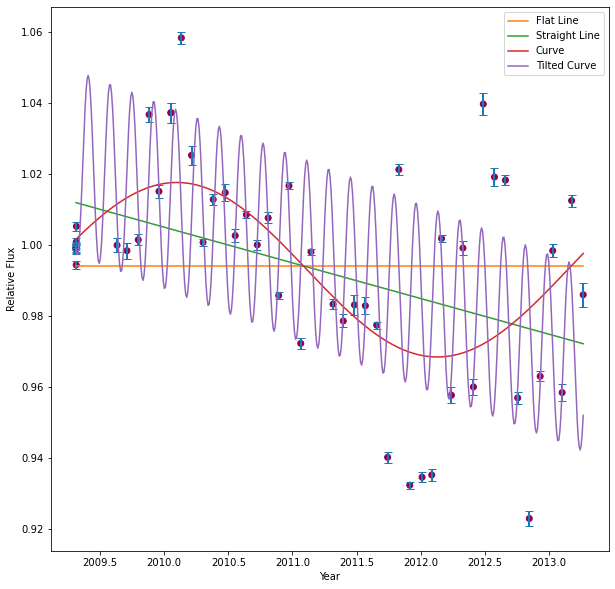

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 17213.417826063323
Straight line L2 error: 14405.89371625766
Curve L2 error: 10533.012607260756
Tilted curve L2 error: 10127.2707691288
Standard deviation: 0.0291561850240302
Number of outliers: 0.0

-- KIC: 1573967 --


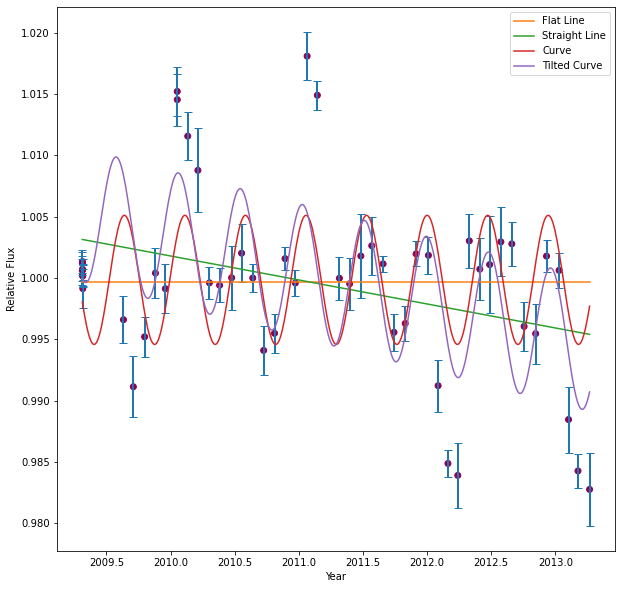

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 898.611096985854
Straight line L2 error: 856.1002608288468
Curve L2 error: 732.4834003466318
Tilted curve L2 error: 578.8916988934525
Standard deviation: 0.0072634328810038
Number of outliers: 0.0

-- KIC: 1574306 --


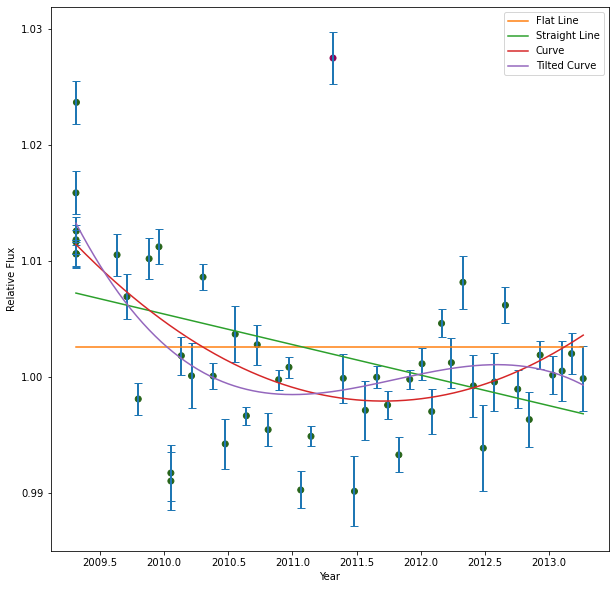

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 1225.5812600932743
Straight line L2 error: 895.9332101633825
Curve L2 error: 577.5337410705441
Tilted curve L2 error: 540.2081815162802
Standard deviation: 0.0078308236007438
Number of outliers: 0.0

-- KIC: 1575570 --


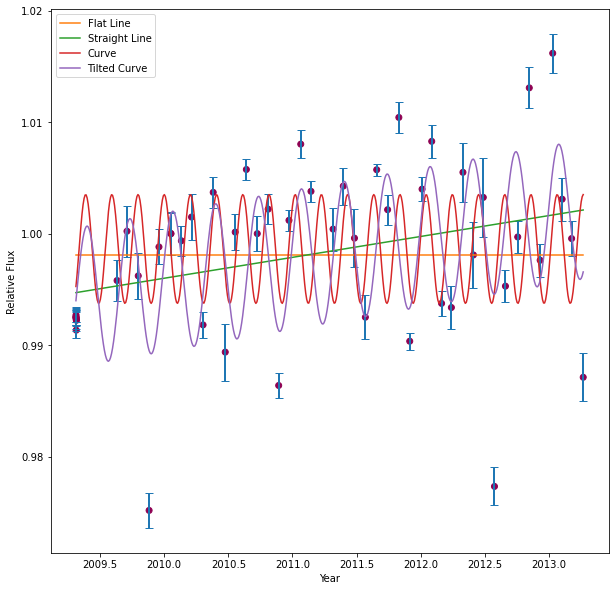

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 1980.823364344355
Straight line L2 error: 1519.9316020189876
Curve L2 error: 1176.5683640777693
Tilted curve L2 error: 1020.7734062236924
Standard deviation: 0.0077246329453598
Number of outliers: 0.0

-- KIC: 1575690 --


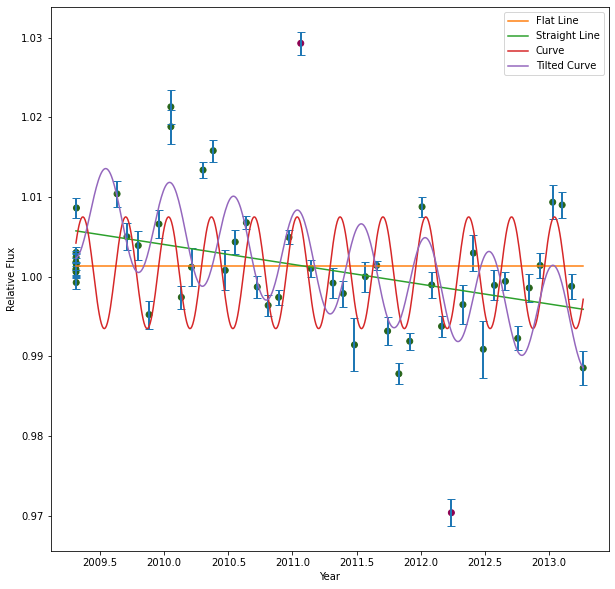

CP/CB: 0.0
EB: 1.0
Flat line L2 error: 1773.548812941037
Straight line L2 error: 1694.0113229336737
Curve L2 error: 1345.4011181198834
Tilted curve L2 error: 1196.112902877741
Standard deviation: 0.0090319070485682
Number of outliers: 0.0

-- KIC: 1575888 --


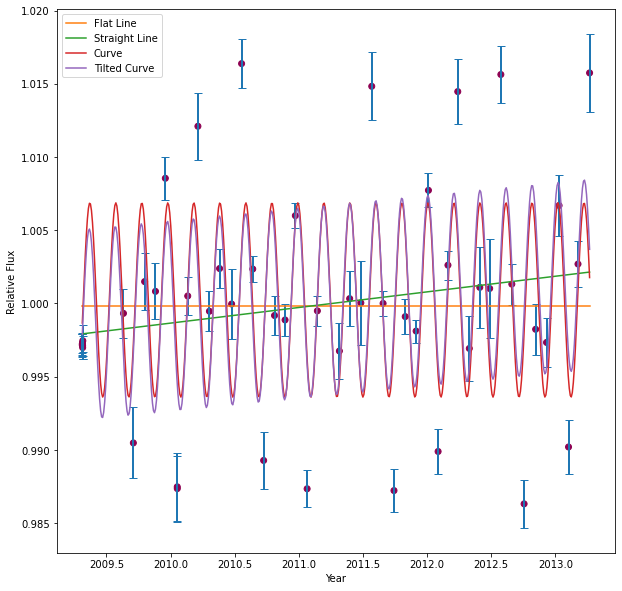

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 999.5647562421932
Straight line L2 error: 940.2065705866324
Curve L2 error: 666.5395049627123
Tilted curve L2 error: 642.8296330957156
Standard deviation: 0.0074816966437939
Number of outliers: 0.0

-- KIC: 1575893 --


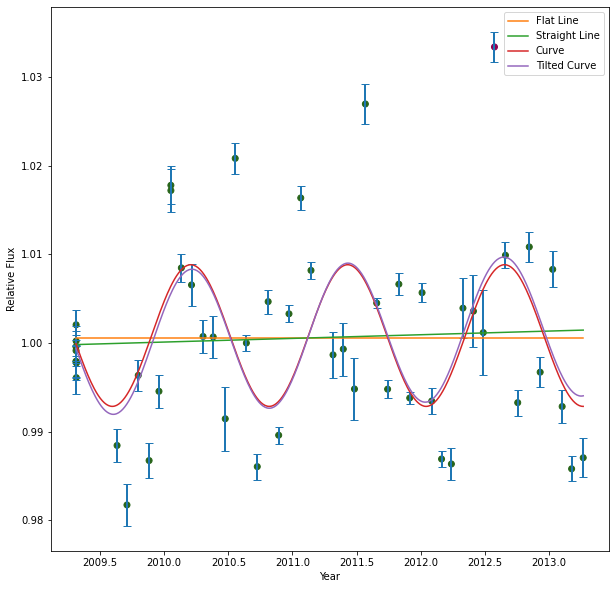

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 2251.186359043258
Straight line L2 error: 2264.213976950813
Curve L2 error: 1638.659976794759
Tilted curve L2 error: 1644.577219705965
Standard deviation: 0.0106085775800662
Number of outliers: 0.0

-- KIC: 1576071 --


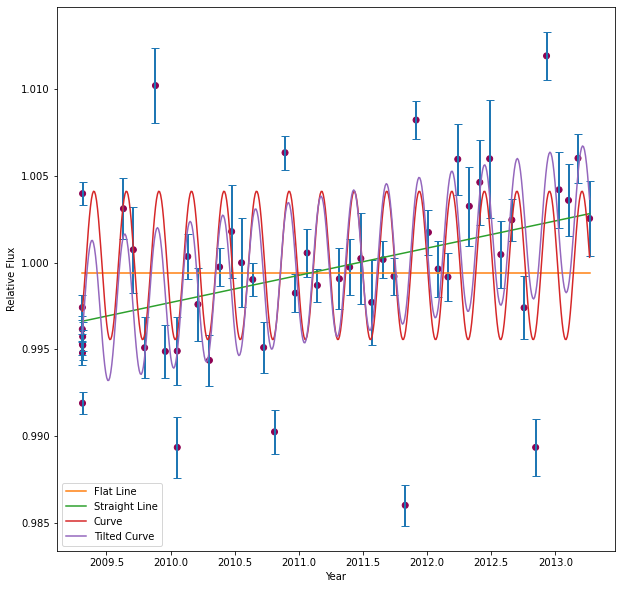

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 929.0865936844704
Straight line L2 error: 728.6983682045333
Curve L2 error: 596.397238262143
Tilted curve L2 error: 536.067328095789
Standard deviation: 0.0052036478633968
Number of outliers: 0.0



In [191]:
# Visualize plots

i = 0
data = short_term()
# data = df[df['KIC'] == 1163244]
# data = data[data['eb'] == 0]
print(len(data))
for kic in data['KIC']:
    # visualize(kic)
    if i > 110 and i < 120:
        visualize(kic)
    i += 1

In [ ]:
# Add two-character flags that indicate each type of variability
# st = short term, mt = medium term, lt = long term, eb = eclipsing binary, nv = non variable

save = df[['KIC']]
save['vt'] = None

funcs = [short_term(), mid_term(), long_term(), eb(), non_var()]
labels = ['st', 'mt', 'lt', 'eb', 'nv']

for i in range(len(funcs)):
    flag = funcs[i]
    flag = pd.merge(df, flag, how='inner', on='KIC')
    for kic in tqdm(flag['KIC']):
        save.at[save[save['KIC'] == kic].index[0], 'vt'] = labels[i]

In [ ]:
save.to_csv("../output/rf_labels.csv", index=False)